In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime,time
import utils as u
import signals
from tqdm import tqdm

### Optimal min peak restriction

In [6]:
changes = np.linspace(0.95,1.00,8)
pnl = []
for change in tqdm(changes):
    signal = signals.signal_analysis(min_peak_change=change)
    pnl.append(signal['return'].sum()) # t takes datetime.time
#     signals.graph_profit(signal)
pnl

100%|██████████| 8/8 [00:51<00:00,  6.50s/it]


[5.470000000000001,
 7.3100000000000005,
 5.1899999999999995,
 3.6400000000000006,
 4.5600000000000005,
 5.010000000000001,
 5.010000000000001,
 5.44]

### Signal data 

In [2]:
signal = signals.signal_analysis(min_peak_change=0.98)
signal

100%|██████████| 40/40 [00:07<00:00,  5.00it/s]


,event_id,minutes,total_corner,line,chl_hi,chl_low,odd_change,peak,peak_change,signal,result_corner,correct_prediction,return
0,20200218TUE13,2020-02-18 01:33:29,7,9.5,2.60,1.43,1.265487,1,0.9470,1,9.0,1,0.43
1,20200218TUE14,2020-02-18 01:30:59,5,7.5,2.48,1.47,1.267241,1,0.9545,1,6.0,1,0.47
2,20200218TUE18,2020-02-18 01:33:11,6,8.5,2.48,1.47,1.267241,1,1.0352,-1,8.0,0,-1.00
3,20200219WED1,2020-02-19 01:36:19,2,3.5,2.43,1.49,1.342342,1,1.0205,-1,7.0,1,1.43
4,20200219WED3,2020-02-19 01:32:28,6,8.5,2.50,1.46,1.280702,1,0.9733,1,7.0,1,0.46
5,20200219WED11,2020-02-19 01:31:04,7,9.5,2.35,1.52,1.288136,1,1.2459,-1,10.0,1,1.35
6,20200219WED16,2020-02-19 01:33:45,2,4.5,2.43,1.49,1.284483,1,0.9675,1,5.0,0,-1.00
7,20200220THU1,2020-02-20 01:32:49,7,9.5,2.50,1.46,1.269565,1,0.9542,1,9.0,1,0.46
8,20200220THU9,2020-02-20 01:31:55,5,7.5,2.45,1.48,1.275862,1,1.0803,-1,9.0,1,1.45
9,20200220THU20,2020-02-20 01:34:58,12,14.5,2.48,1.47,1.278261,1,0.9545,1,13.0,1,0.47


### Looking at graphs of wrongly predicted games

In [5]:
wrong_predictions = signal[signal.correct_prediction == 0]# ['event_id']
wrong_predictions

,event_id,minutes,total_corner,line,chl_hi,chl_low,odd_change,peak,peak_change,signal,result_corner,correct_prediction,return
2,20200218TUE18,2020-02-18 01:33:11,6,8.5,2.48,1.47,1.267241,1,1.0352,-1,8.0,0,-1.0
6,20200219WED16,2020-02-19 01:33:45,2,4.5,2.43,1.49,1.284483,1,0.9675,1,5.0,0,-1.0
13,20200221FRI35,2020-02-21 01:33:07,7,9.5,2.45,1.48,1.275862,1,0.9610,1,11.0,0,-1.0
14,20200222SAT1,2020-02-22 01:36:37,8,10.5,2.45,1.48,1.243697,1,0.9673,1,12.0,0,-1.0
15,20200222SAT6,2020-02-22 01:30:33,10,14.5,3.10,1.31,1.031496,1,0.8291,1,15.0,0,-1.0
17,20200222SAT13,2020-02-22 01:31:41,8,10.5,2.48,1.47,1.267241,1,1.0889,-1,8.0,0,-1.0
18,20200222SAT16,2020-02-22 01:38:54,8,10.5,2.48,1.47,1.267241,1,0.9608,1,12.0,0,-1.0
21,20200222SAT52,2020-02-22 01:35:01,2,4.5,2.58,1.44,1.274336,1,0.9536,1,5.0,0,-1.0
22,20200222SAT55,2020-02-22 01:35:30,10,12.5,2.58,1.44,1.210084,1,1.0286,-1,10.0,0,-1.0
27,20200223SUN17,2020-02-23 01:37:39,7,8.5,2.60,1.43,1.265487,1,0.9533,1,9.0,0,-1.0


In [39]:
# for game in wrong_predictions:
#     data = signals.signal_data_pipeline(game)
#     u.graph(data.minutes,data.line,'Plot')

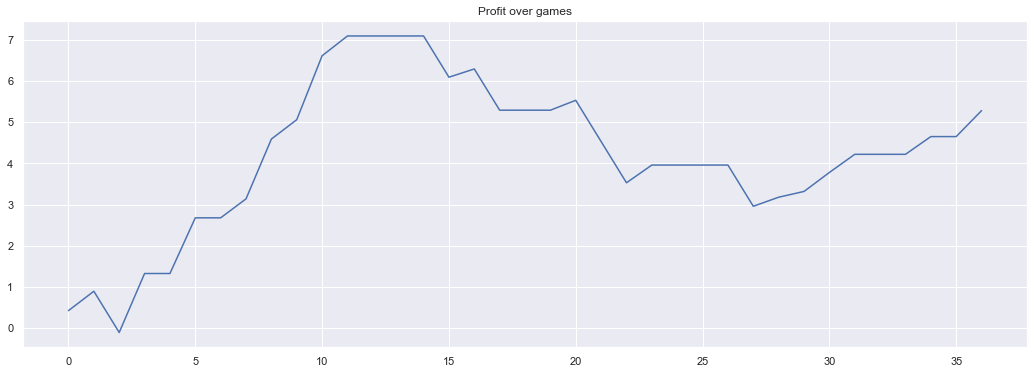

In [42]:
signal = signals.signal_analysis(t=time(1,30,0), min_peak_change=0.96)
signals.graph_profit(signal)

### Plot one game

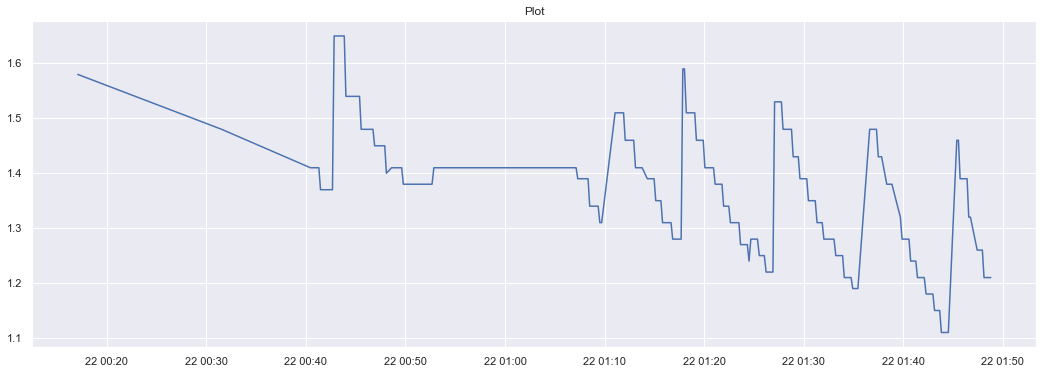

In [7]:
data = signals.signal_data_pipeline('20200222SAT1')
u.graph(data.minutes,data.chl_low,'Plot')

### chl_line change graph

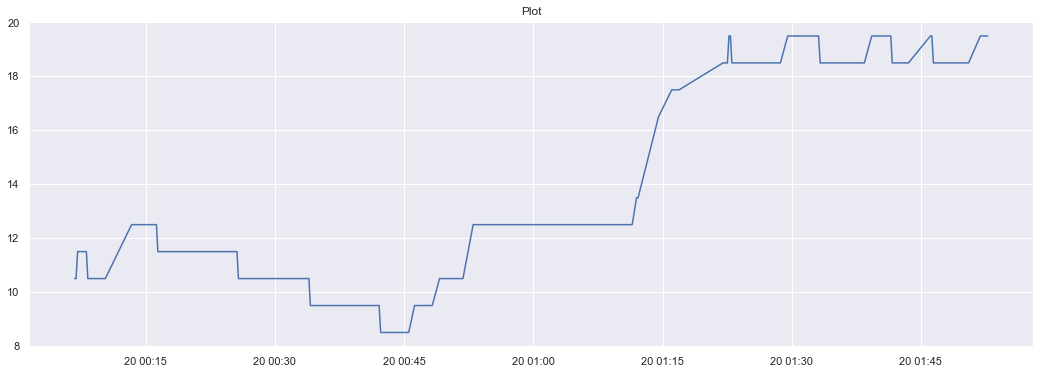

          event_id             minutes  total_corner  line  chl_hi  chl_low
0    20200220THU22 2020-02-20 00:06:45             0  10.5    2.02     1.70
1    20200220THU22 2020-02-20 00:06:55             0  10.5    2.02     1.70
2    20200220THU22 2020-02-20 00:07:06             0  11.5    2.60     1.43
3    20200220THU22 2020-02-20 00:07:06             0  11.5    2.60     1.43
4    20200220THU22 2020-02-20 00:07:16             0  11.5    2.60     1.43
..             ...                 ...           ...   ...     ...      ...
907  20200220THU22 2020-02-20 01:52:04            18  19.5    4.00     1.20
908  20200220THU22 2020-02-20 01:52:14            18  19.5    4.00     1.20
909  20200220THU22 2020-02-20 01:52:24            18  19.5    4.00     1.20
910  20200220THU22 2020-02-20 01:52:35            18  19.5    4.50     1.16
911  20200220THU22 2020-02-20 01:52:45            18  19.5    4.70     1.15

[912 rows x 6 columns]


In [25]:
data = signals.signal_data_pipeline('20200220THU22')
u.graph(data.minutes,data.line,'Plot')
print(data)

### Baseline model
Random bet on lowest chl_low at a specified t

In [37]:
def baseline_model(t):
    signal_list = None
    for event_id in [file[:-4] for file in os.listdir('data/') if '2020' in file]:
        # data pipeline
        data = signals.signal_data_pipeline(event_id)
        data = data[data.minutes >= datetime.combine(datetime.strptime(event_id[:8],"%Y%m%d"), t)]
        peaks = data
        if signal_list is None:
            if peaks.empty == False:
                signal_list = peaks.iloc[[0]]
        else:
            if peaks.empty == False:
                signal_list = pd.concat([signal_list, peaks.iloc[[0]]], ignore_index=True)

    # merge current results
    result = pd.read_csv('/Users/TysonWu/dev/odds-crawl-app/odds-crawl-app/development/result_collection/match_corner_result.csv')
    signal = signal_list.merge(result[['event_id', 'result_corner']], how='inner', on='event_id')

    # exclude games without results
    signal = signal[~signal.result_corner.isna()]

    # calculate return
    signal['correct_prediction'] = np.where(signals.line > signal.result_corner, 1, 0)
    signal['return'] = np.where(signal.correct_prediction == 1, signal.chl_low-1, -1)
    signal = signal.sort_values(by='event_id').reset_index(drop=True)
    return signal['return'].sum()

In [38]:
from tqdm import tqdm
from datetime import date

# timelist = [time(0,i,0) for i in range(60)] + [time(1,i,0) for i in range(36)]
timelist = [time(1,i,0) for i in range(36)]
pnl = []
for times in tqdm(timelist):
    profit = baseline_model(t=times)
    pnl.append(profit) # t takes datetime.time

u.graph([datetime.combine(date.today(), time)for time in timelist], pnl, 'Return against baseline at t')

  0%|          | 0/36 [00:07<?, ?it/s]


AttributeError: module 'signals' has no attribute 'line'

## Supervised machine learning model

In [2]:
from datetime import datetime, time
import math
import signals
from tqdm import tqdm
import pandas as pd

# read and concat signal analysis data with different t restriction
df = None
t=[time(1,i,0) for i in range(0,35,5)]
for t in tqdm(t):
    temp = signals.signal_analysis(t)
    if df is None:
        df = temp
    else:
        df = pd.concat([df, temp])
df.reset_index(drop=True)

100%|██████████| 7/7 [00:34<00:00,  4.99s/it]


,event_id,minutes,total_corner,line,chl_hi,chl_low,odd_change,peak,peak_change,signal,result_corner,correct_prediction,return
0,20200218TUE13,2020-02-18 01:05:32,5,10.5,2.27,1.56,1.209302,1,1.0065,0,9.0,0,0.00
1,20200218TUE14,2020-02-18 01:11:48,3,7.5,2.17,1.61,1.238462,1,0.9938,0,6.0,0,0.00
2,20200218TUE18,2020-02-18 01:08:51,5,9.5,2.25,1.57,1.226562,1,1.1056,-1,8.0,0,-1.00
3,20200218TUE20,2020-02-18 01:03:40,5,11.5,2.95,1.34,1.022901,1,0.8481,1,11.0,1,0.34
4,20200219WED1,2020-02-19 01:07:51,1,5.5,2.38,1.51,1.217742,1,0.9557,1,7.0,0,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,20200222SAT18,2020-02-22 01:32:40,8,10.5,2.55,1.45,1.271930,1,0.9797,1,8.0,1,0.45
161,20200222SAT22,2020-02-22 01:31:06,12,15.5,3.60,1.24,1.008130,1,0.8158,1,14.0,1,0.24
162,20200222SAT52,2020-02-22 01:35:01,2,4.5,2.58,1.44,1.274336,1,0.9536,1,5.0,0,-1.00
163,20200222SAT6,2020-02-22 01:30:33,10,14.5,3.10,1.31,1.031496,1,0.8291,1,15.0,0,-1.00


In [4]:
import numpy as np
df = df.drop_duplicates(keep='first')
df['corner_line_diff'] = (df.line - df.total_corner).apply(lambda x: math.floor(x))
df['seconds_since_start'] = df.minutes.apply(lambda x: 
                                         int(x.strftime('%H'))*60*60
                                        +int(x.strftime('%M'))*60
                                        +int(x.strftime('%S')))
df['is_low'] = np.where(df.line > df.result_corner, 1, 0)

In [6]:
# XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [7]:
X, y = df[['total_corner','line','chl_low','odd_change','peak_change','corner_line_diff','seconds_since_start']], df[['is_low']]

In [8]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.492723


In [10]:
params = {"objective":"reg:logistic",'colsample_bytree': 0.5,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.5,0.0,0.5,0.0


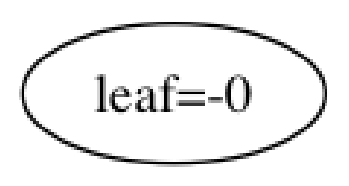

In [12]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

In [13]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

ValueError: Booster.get_score() results in empty

## Neural network

In [20]:
import tensorflow as tf
from tensorflow import keras

X, y = df[['total_corner','line','chl_low','odd_change','peak_change','corner_line_diff','seconds_since_start']], df[['is_low']]
dataset = tf.data.Dataset.from_tensor_slices((X.values, y.values))
train_dataset = dataset.shuffle(len(df)).batch(1)


In [21]:
model = tf.keras.Sequential([
tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(train_dataset, epochs=15)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/15
98/98 [==============================] - 1s 13ms/step - loss: nan - accuracy: 0.4898
Epoch 2/15
98/98 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.4898
Epoch 3/15
98/98 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.4898
Epoch 4/15
98/98 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.4898
Epoch 5/15
98/98 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.4898
Epoch 6/15
98/98 [==============